In [1]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import torch
from torch import nn 
import torch.nn.functional as F

warnings.filterwarnings("ignore")

# Data loading

In [2]:
train_dataset = pd.read_csv("../data/internal/train_dataset.csv")
val_dataset = pd.read_csv("../data/internal/val_dataset.csv")

train_targets = pd.read_csv("../data/internal/train_targets.csv")
val_targets = pd.read_csv("../data/internal/val_targets.csv")

train_masks = pd.read_csv("../data/internal/train_masks.csv")['movie_ids']
val_masks = pd.read_csv("../data/internal/val_masks.csv")['movie_ids']

In [3]:
def convert_mask(train_masks):
    ans = []
    for elem in train_masks:
        ans.append([int(x) for x in elem[1:-1].split(', ')])
    return ans

train_masks = convert_mask(train_masks.tolist())
val_masks = convert_mask(val_masks.tolist())

# Model

In [4]:
device = "cuda"  if torch.cuda.is_available() else 'cpu'

In [5]:
X_train = torch.Tensor(train_dataset.values).to(device)
Y_train = torch.Tensor(train_targets.values).to(device)
X_val = torch.Tensor(val_dataset.values).to(device)
Y_val = torch.Tensor(val_targets.values).to(device)

In [6]:
len(X_train[0])

1705

In [7]:
class RecSys(nn.Module):
    def __init__(
        self
    ):
        super(RecSys, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1705, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU()
        )
        self.head = nn.Linear(2048, 1682)

    def forward(self, x):
        deep_logits = self.linear_relu_stack(x)
        total_logits = self.head(deep_logits)
        return F.sigmoid(total_logits)

In [8]:
model = RecSys().to(device)

In [9]:
def build_mask(size, offset, indexes):
    mask = [True for _ in range(size)]
    for elem in indexes:
        mask[elem+offset-1] = False
    return torch.tensor(mask)

In [10]:
def mask_target(target, masks):
    masked = []
    for i in range(len(target)):
        elem = target[i]
        mask = build_mask(len(elem), 0, masks[i]).to(device)
        masked_elem =  torch.masked_select(elem, mask)
        masked.append(masked_elem)
    return torch.stack(masked)

def mask_one_row(target, mask):
    torch_mask = build_mask(len(target), 0, mask).to(device)
    return torch.masked_select(target, torch_mask)

Y_train_masked  = mask_target(Y_train, train_masks)
Y_val_masked = mask_target(Y_val, val_masks)

In [11]:
EPOCHS = 500
SAVE_STEP = 5
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_score = 999999
best_epoch = 0

t = trange(EPOCHS)
for i in t:
    model.train()
    pred_train = model(X_train)
    masked_pred_train = mask_target(pred_train, train_masks)
    loss_train = loss_fn(masked_pred_train, Y_train_masked)
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        pred_val = model(X_val)
        masked_pred_val = mask_target(pred_val, val_masks)
        loss_val = loss_fn(masked_pred_val, Y_val_masked)
        if loss_val < best_score:
            best_score = loss_val
            best_epoch = i+1
            torch.save(model, "../models/best_model")
    
    t.set_description(f"Train loss: {loss_train:>7f}\tVal loss: {loss_val:>7f}\tLowest val loss: {best_score:>7f}", refresh=True)
    if (i+1) % SAVE_STEP == 0:
        torch.save(model, f"../models/checkpoint_{i+1}_model")
torch.save(model, "../models/latest_model")

Train loss: 0.003436	Val loss: 0.803746	Lowest val loss: 0.167018: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s]


In [12]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    # if not actual:
    #     return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [13]:
def evaluate_model(model, K=[5, 10, 20, 50], show = True):
    actuals = []
    predictions = []
    for i in range(len(Y_val)):
        probs = model(X_val[i])
        probs = mask_one_row(probs, val_masks[i])
        temp = probs.detach().cpu().numpy()
        act = Y_val_masked[i].detach().cpu().numpy()
        actuals.append(np.argsort(act)[len(act)-int(sum(act)):])
        predictions.append(np.argsort(temp)[::-1])    
    
    ans = []
    for k in K:
        elem = mapk(actuals, predictions, k)
        ans.append(elem)
        if show:
            print(f"K={k}\tMAP@K: {elem}")
    return ans


model = torch.load("../models/best_model").to(device)
best_model_metrics = evaluate_model(model)

K=5	MAP@K: 0.4957801418439716
K=10	MAP@K: 0.42785017730496455
K=20	MAP@K: 0.3657245024725549
K=50	MAP@K: 0.3147194640482372


In [14]:
model = torch.load("../models/latest_model").to(device)
evaluate_model(model)

K=5	MAP@K: 0.3935638297872341
K=10	MAP@K: 0.3207645221209051
K=20	MAP@K: 0.2717211250199237
K=50	MAP@K: 0.23250316562018347


[0.3935638297872341,
 0.3207645221209051,
 0.2717211250199237,
 0.23250316562018347]

In [18]:
metrics = []
steps = []
highest = 0
highest_metric = 0
for i in range(SAVE_STEP, EPOCHS+SAVE_STEP, SAVE_STEP):
    steps.append(i)
    model = torch.load(f"../models/checkpoint_{i}_model").to(device)
    value = evaluate_model(model, show = False)
    metrics.append(value)
    if value[0] > highest_metric:
        highest_metric = value[0]
        highest = i
highest

190

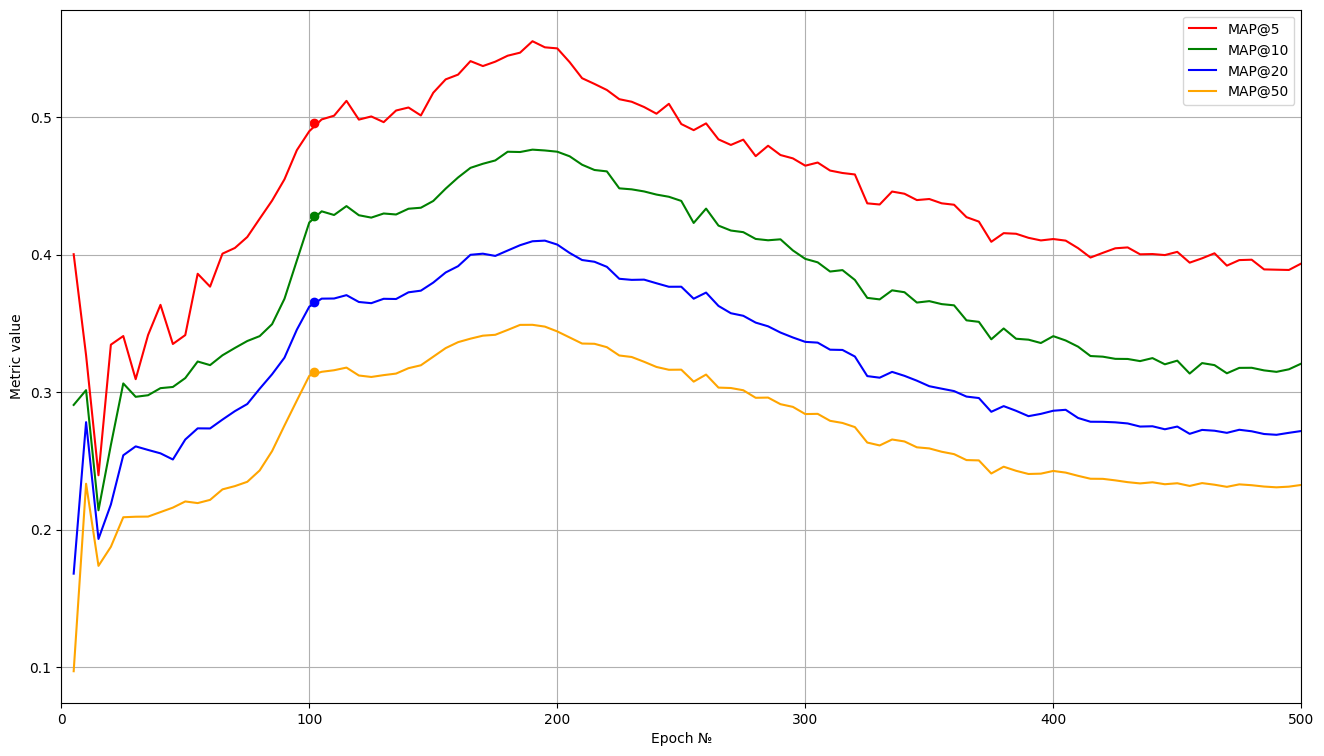

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))
map_5 = [x[0] for x in metrics]
map_10 = [x[1] for x in metrics]
map_20 = [x[2] for x in metrics]
map_50 = [x[3] for x in metrics]
ax.plot(steps, map_5, label = "MAP@5", color='r')
ax.plot(steps, map_10, label = "MAP@10", color='g')
ax.plot(steps, map_20, label = "MAP@20", color='b')
ax.plot(steps, map_50, label = "MAP@50", color='orange')

ax.scatter(best_epoch, best_model_metrics[0], color='r')
ax.scatter(best_epoch, best_model_metrics[1], color='g')
ax.scatter(best_epoch, best_model_metrics[2], color='b')
ax.scatter(best_epoch, best_model_metrics[3], color='orange')

plt.xlim([0, steps[-1]])
plt.xlabel("Epoch №")
plt.ylabel("Metric value")
plt.legend()
plt.grid()
plt.savefig("../reports/figures/validation.png")
plt.show()

As we can see, model which was trained over 190 epochs has best metrics values. (Actually metrics might be slight different due to train process stochasticity, however from my observations best metrics are usually from 180 to 200.) Let's say that this would be our best RecSys model that we can suggest. As for model with lowest BSELoss - it has solid performance, however as we already seen, lower BSELoss doesn't always imply higher MAP@K metric value.